In [1]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics
from copy import copy


In [2]:
time_dome = str(4)
folder_and_dome = str('./../../../../Desktop/dome70_tp'+time_dome+'_fallingline/70_denoised_tp')
wd = folder_and_dome + time_dome

In [3]:
image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

hull_top_line = sk.io.imread(wd+'_hull_top_line_0.tif')
hull_top_line_r = common_functions.get_image_r(hull_top_line)

epithelial_dots = sk.io.imread(wd+'_apical_dots_total_epithelial_1.tif')
gaussian_dots = sk.io.imread(wd+'_apical_dots_total_gaussian_1.tif')
total_dots = sk.io.imread(wd+'_apical_dots_total_1.tif')

epithelial_dots_r = common_functions.get_image_r(epithelial_dots)
gaussian_dots_r = common_functions.get_image_r(gaussian_dots)
total_dots_r = common_functions.get_image_r(total_dots)


(550, 858, 858)


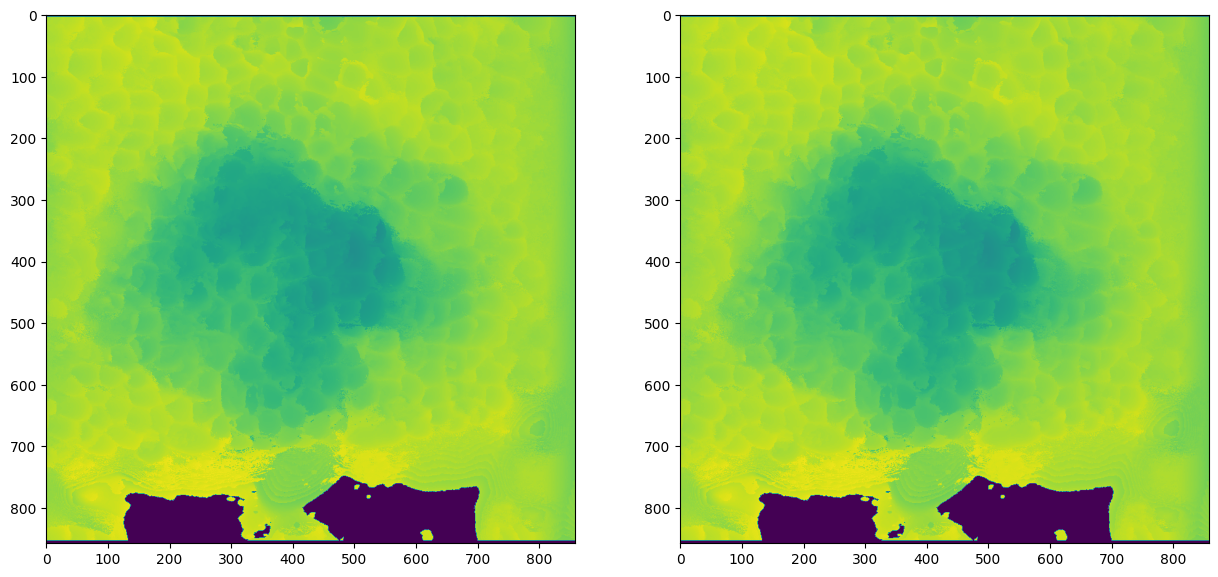

In [4]:
heightmap = common_functions.get_heightmap(total_dots)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(heightmap)

print(total_dots.shape)

# remove all up heightmap
total_dots_threshold_heightmap = copy(total_dots)

for x in range(heightmap.shape[0]):
    for y in range(heightmap.shape[1]):
        threshold_value = heightmap[x, y]
        total_dots_threshold_heightmap[:threshold_value, x, y] = 0

plt.subplot(122)
plt.imshow(common_functions.get_heightmap(total_dots_threshold_heightmap))


In [32]:
tiff.imwrite(f'{wd}_apical_dots_total_1_threshold_heightmap.tif', common_functions.normalize_image(total_dots_threshold_heightmap, 255).astype(np.uint16))

Try delaunay

In [15]:
from scipy.spatial import Delaunay


class MyDelaunay(Delaunay):
    def __init__(self, points, delaunay_to_2D):
        super().__init__(points)
        self.delaunay_to_2D = delaunay_to_2D
        if delaunay_to_2D:
            self.simplices = self.convert_to_2D(self.simplices)
            
    def convert_to_2D(self, simplex):
        simplex_2D = []
        for i in simplex:
            simplex_2D.append([i[0], i[1], i[2]])
            simplex_2D.append([i[0], i[1], i[3]])
            simplex_2D.append([i[0], i[2], i[3]])
            simplex_2D.append([i[1], i[2], i[3]])
        return np.array(simplex_2D)

    def triangle_area(self, simplex): # At the moment only working in 2D triangles
        p1, p2, p3 = self.points[simplex]
        return 0.5 * np.abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

    def calculate_triangle_areas(self):
        return [self.triangle_area(simplex) for simplex in self.simplices]

    def largest_triangle_angle(self):
        largest_angles = []

        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]

            # Calculate vectors
            v1 = p2 - p1
            v2 = p3 - p1
            v3 = p3 - p2

            # Calculate angles
            angle1 = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angle2 = np.arccos(np.dot(-v1, v3) / (np.linalg.norm(v1) * np.linalg.norm(v3)))
            angle3 = np.pi - angle1 - angle2

            largest_angle = max(angle1, angle2, angle3)
            largest_angles.append(np.degrees(largest_angle))

        return largest_angles
    
    def largest_triangle_side(self):
        largest_sides = []
        
        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]
            largest_side = max([np.sqrt((p1[0]-p1[1])**2+(p2[0]-p2[1])**2),
                                np.sqrt((p1[0]-p1[1])**2+(p3[0]-p3[1])**2),
                                np.sqrt((p2[0]-p2[1])**2+(p3[0]-p3[1])**2)])
            largest_sides.append(largest_side)
        
        return largest_sides
    

def delaunay(i, threshold_area, threshold_angle, delaunay_to_2D=True):
    '''
    '''  
    tri = MyDelaunay(i, delaunay_to_2D)
    # Calculate triangle areas and largest angles
    triangle_areas = np.array(tri.calculate_triangle_areas())
    largest_angles = np.array(tri.largest_triangle_angle())

    # Create masks based on thresholds
    mask_area = (triangle_areas - triangle_areas.mean()) < threshold_area * triangle_areas.std()
    mask_angle = largest_angles < threshold_angle

    # Combine masks using logical AND (you can also use | for OR)
    combined_mask = mask_area & mask_angle

    filtered_simplices = tri.simplices[combined_mask]

    
    return filtered_simplices

def get_coords(i):
    coords = np.transpose(np.nonzero(i != 0))
    
    return coords

def bresenham_line(self, x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy
    x, y = x1, y1

    while True:
        points.append((x, y))
        if x == x2 and y == y2:
            break
        e2 = 2 * error
        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

def bresenham_line_3d(x1, y1, z1, x2, y2, z2):
    ListOfPoints = []
    ListOfPoints.append((x1, y1, z1))
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)
    if (x2 > x1):
        xs = 1
    else:
        xs = -1
    if (y2 > y1):
        ys = 1
    else:
        ys = -1
    if (z2 > z1):
        zs = 1
    else:
        zs = -1

    # Driving axis is X-axis"
    if (dx >= dy and dx >= dz):        
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while (x1 != x2):
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Y-axis"
    elif (dy >= dx and dy >= dz):       
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while (y1 != y2):
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Z-axis"
    else:        
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while (z1 != z2):
            z1 += zs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dz
            if (p2 >= 0):
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
            ListOfPoints.append((x1, y1, z1))
            
    return ListOfPoints





Get the triangles from the total dots

In [16]:
coords = get_coords(total_dots)
filtered_simplices = delaunay(coords, 0.1, 90, delaunay_to_2D=True)

mask = np.zeros((total_dots.shape))
for i in filtered_simplices:
    
    to_1 = bresenham_line_3d(*coords[i][0], *coords[i][1])
    to_1 += list(bresenham_line_3d(*coords[i][1], *coords[i][2]))
    to_1 += list(bresenham_line_3d(*coords[i][0], *coords[i][2]))
    for j in to_1:
        mask[j] = 1

tiff.imwrite(f'{wd}_apical_dots_total_1_delaunay.tif', common_functions.normalize_image(mask, 255).astype(np.uint16))

Get 3d heightmap

(550, 858, 858)
736164.0


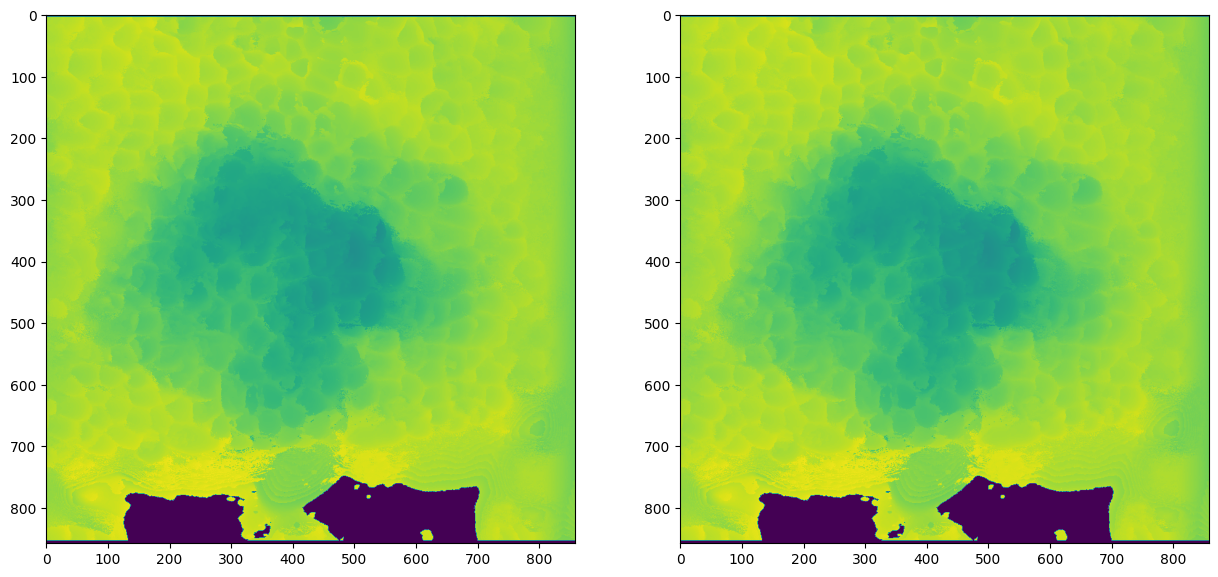

In [19]:
heightmap = common_functions.get_heightmap(total_dots)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(heightmap)

print(total_dots.shape)

# remove all up heightmap
d3heightmap = np.zeros((total_dots.shape))

for x in range(heightmap.shape[0]):
    for y in range(heightmap.shape[1]):
        threshold_value = heightmap[x, y]
        d3heightmap[threshold_value, x, y] = 1

plt.subplot(122)
plt.imshow(common_functions.get_heightmap(d3heightmap))

print(d3heightmap.sum())
tiff.imwrite(f'{wd}_apical_dots_total_1_3dheightmap.tif', common_functions.normalize_image(d3heightmap, 255).astype(np.uint16))


Get triangles only from the top surface

In [24]:
coords_hm = get_coords(d3heightmap)
rows_with_zero = np.any(coords_hm == 0, axis=1)
coords_hm = coords_hm[~rows_with_zero]

filtered_simplices_hm = delaunay(coords_hm, 0.1, 90, delaunay_to_2D=True)
mask_hm = np.zeros((total_dots.shape))
for i in filtered_simplices_hm:
    to_1 = bresenham_line_3d(*coords_hm[i][0], *coords_hm[i][1])
    to_1 += list(bresenham_line_3d(*coords_hm[i][1], *coords_hm[i][2]))
    to_1 += list(bresenham_line_3d(*coords_hm[i][0], *coords_hm[i][2]))
    for j in to_1:
        mask_hm[j] = 1

In [26]:
tiff.imwrite(f'{wd}_apical_dots_total_1_hm_triangulated.tif', common_functions.normalize_image(mask_hm, 255).astype(np.uint16))

Quantify good dots vs bad dots........

In [51]:
# # image*dots
# norm_image = common_functions.normalize_image(image, 10000).astype(np.uint16)

# tiff.imwrite(f'{wd}_apical_dots_total_1_norm_image.tif', common_functions.normalize_image(norm_image, 65535).astype(np.uint16))

# image_dots = common_functions.get_3D_gaussian(total_dots,3)

# image_dots = common_functions.normalize_image(image_dots, 1)*norm_image

# tiff.imwrite(f'{wd}_apical_dots_total_1_times_image.tif', common_functions.normalize_image(image_dots, 65535).astype(np.uint16))

# image_substract = norm_image-image_dots

# tiff.imwrite(f'{wd}_apical_dots_total_1_substract_image.tif', common_functions.normalize_image(image_substract, 65535).astype(np.uint16))


65535
65535
uint32


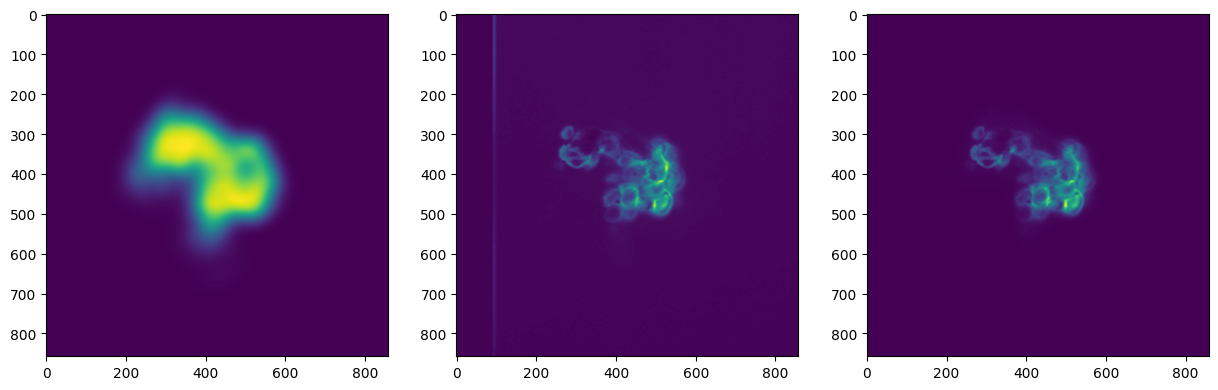

In [64]:
gaussian_multiply = sk.io.imread(wd+'_apical_dots_total_gaussian_1.tif')
image_multiply = sk.io.imread(wd+'_apical_dots_total_1_substract_image.tif')

print(gaussian_multiply.max())
print(image_multiply.max())

epithelial = gaussian_multiply.astype(np.uint32)*image_multiply.astype(np.uint32)
print(epithelial.dtype)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(gaussian_multiply[300])
plt.subplot(132)
plt.imshow(image_multiply[300])
plt.subplot(133)
plt.imshow(epithelial[300])

tiff.imwrite(f'{wd}_wierd_epithelial.tif', common_functions.normalize_image(epithelial, 65535).astype(np.uint16))


def shape_finder_2D(epithelial, angle=40):
    '''
    Falling line algorithm for 2D front image rotation, delta degree = 20º
    - epithelial is the 2D image that has to be fed from front
    - angle is the max rotation for the 2D image
    '''

    angles = [i for i in range(-angle, angle+1, 10)]
    # angles = [-40]
    total_cell_mask = np.zeros(shape=(epithelial.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(epithelial, angle, reshape=False) # Be careful of the reshape=False
        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))

            if max_pos <= len(col)*0.95 and max_pos >= len(col)*0.05 and max(col) >= col.mean()+2*col.std(): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos) # Search for the max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

epithelial_r = common_functions.get_image_r(epithelial)
apical_dots_r = Parallel(n_jobs=-1)(delayed(shape_finder_2D)(i) for i in epithelial_r)


In [65]:
apical_dots_prova = np.transpose(apical_dots_r, axes=(1,2,0))

In [66]:
tiff.imwrite(f'{wd}_apical_dots_apical_dots_prova.tif', common_functions.normalize_image(apical_dots_prova, 65535).astype(np.uint16))


In [67]:
tiff.imwrite(f'{wd}_empty.tif', common_functions.normalize_image(np.zeros((apical_dots_prova.shape)), 65535).astype(np.uint16))


: 